In [ ]:
# connect to my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# create shortcut do datasets folder
!ln -s "/content/drive/MyDrive/Datasets" "/content/Datasets"

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import numpy as np
from shutil import copyfile
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

In [ ]:
# image data generator
TRAINING_DIR = "/content/Datasets/skin_diseases/train/"
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

VALIDATION_DIR = "/content/Datasets/skin_diseases/test/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))

Found 1278 images belonging to 4 classes.
Found 321 images belonging to 4 classes.


In [ ]:
def create_pre_trained_model():
  IMG_SHAPE = (224, 224, 3)
  pre_trained_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                        include_top=False,
                                                        weights='imagenet')

  # Make all the layers in the pre-trained model non-trainable
  # for layer in pre_trained_model.layers:
  pre_trained_model.trainable = False

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model()

# Print the model summary
pre_trained_model.summary()

12683000/12683000 [==============================] - 0s 0us/step
Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                  

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 2,996,352 total parameters in this model.
There are 0 trainable parameters in this model.


In [ ]:
# build model
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5"),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.build([None, 224, 224, 3])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    # optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 4,317,997 total parameters in this model.
There are 777,732 trainable parameters in this model.


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 flatten_4 (Flatten)         (None, 1001)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               513024    
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 4,317,997
Trainable params: 777,732
Non-trainable params: 3,540,265
_________________________________________________________________


In [ ]:
# Define a Callback class that stops training once accuracy reaches 85.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(
       logs.get('accuracy') is not None and
       logs.get('accuracy') > 0.85 and
       logs.get('val_accuracy') > 0.85 and
       logs.get('accuracy') - logs.get('val_accuracy') < 0.05
      ):
      print("\nReached 85% accuracy and validation accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=100,
                    verbose=1,
                    callbacks=[callbacks]
                    )

Epoch 1/100
40/40 [==============================] - 45s 1s/step - loss: 1.5101 - accuracy: 0.4202 - val_loss: 0.7380 - val_accuracy: 0.7290
Epoch 2/100
40/40 [==============================] - 25s 624ms/step - loss: 0.8993 - accuracy: 0.6393 - val_loss: 0.6149 - val_accuracy: 0.7664
Epoch 3/100
40/40 [==============================] - 24s 593ms/step - loss: 0.7995 - accuracy: 0.6800 - val_loss: 0.5663 - val_accuracy: 0.7882
Epoch 4/100
40/40 [==============================] - 24s 608ms/step - loss: 0.7392 - accuracy: 0.7113 - val_loss: 0.5705 - val_accuracy: 0.7819
Epoch 5/100
40/40 [==============================] - 23s 586ms/step - loss: 0.6655 - accuracy: 0.7371 - val_loss: 0.5150 - val_accuracy: 0.8131
Epoch 6/100
40/40 [==============================] - 23s 587ms/step - loss: 0.6427 - accuracy: 0.7426 - val_loss: 0.4999 - val_accuracy: 0.8193
Epoch 7/100
40/40 [==============================] - 23s 583ms/step - loss: 0.6047 - accuracy: 0.7520 - val_loss: 0.4878 - val_accuracy: 0.

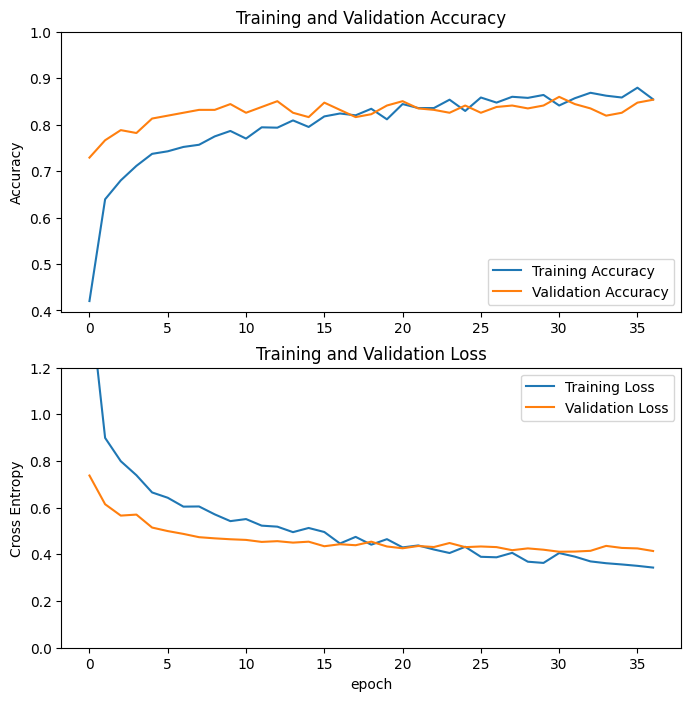

In [ ]:
# print accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# plot loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# print Last validation accuracy and loss from the model training process
print(f"Last validation accuracy: {(val_acc[-1]):.4f}")
print(f"Last validation loss: {(val_loss[-1]):.4f}")

# print Last training accuracy and loss from the model training process
print(f"Last training accuracy: {(acc[-1]):.4f}")
print(f"Last training loss: {(loss[-1]):.4f}")

Last validation accuracy: 0.8536
Last validation loss: 0.4145
Last training accuracy: 0.8545
Last training loss: 0.3435


In [ ]:
# save the model
model.save("/content/Datasets/model_skin_diseases.h5")

In [ ]:
model = tf.keras.models.load_model(
        ('/content/drive/MyDrive/Models/model_skin_diseases.h5'),
        custom_objects={'KerasLayer':hub.KerasLayer}
    )

In [ ]:
from PIL import Image

# Provide the path to the uploaded image
image_path = "/content/dip.jpg"

# Load and preprocess the image
image = Image.open(image_path)
image = image.resize((224, 224))  # Resize the image to match the model's input size
image = np.array(image)
image = image / 255.0  # Normalize the image pixel values
image = np.expand_dims(image, axis=0)  # Add a batch dimension


In [ ]:
# Get the class indices from the generator
class_indices = train_generator.class_indices

# Invert the dictionary to get the mapping from indices to class names
index_to_class = {v: k for k, v in class_indices.items()}

# Print the index and class name for each class
for index in sorted(index_to_class.keys()):
    class_name = index_to_class[index]
    print("Index:", index, " - Class Name:", class_name)

In [ ]:
# Prediction
predictions = model.predict(image)
print(predictions)

1/1 [==============================] - 0s 35ms/step
[[0.10546884 0.16622283 0.15730904 0.5709993 ]]


In [ ]:
class_labels = ["Acne", "Black Spot", "Puff Eye", "Wrinkle"]

predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class label:", predicted_class_label)
print(f"Accuracy: {predictions[0][predicted_class_index]:.4f}")

Predicted class label: Wrinkle
Accuracy: 0.5710


In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('/content/Datasets/skin_diseases_model.tflite', 'wb') as f:
    f.write(tflite_model)